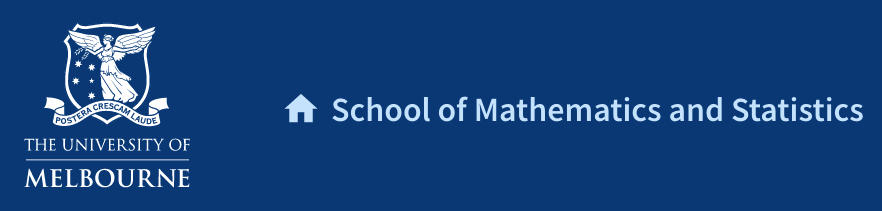

# MAST 90014 - Individual assignment - 2023

`Attention: Do not put your name nor student number in this document. Identification will be made automatically in canvas submission.`

---
## `Data`
---

In [1]:
import math

#Plants data
P = range(3) #P
pcap = [300000, 250000, 200000] #c_p


#Clients
C = range(4)
dem = [[10000, 10000, 10000, 20000],
     [20000, 10000, 10000, 10000],
     [30000, 30000, 20000, 20000], 
     [20000, 30000, 20000, 10000]] 



#Commodities
K = range(4)
cons = [1,2,3,4] 
weig = [1,3,5,4] 

#P x K production cost
prcost = [[4, 2.5, 2.0, 1.5],
     [3.0, 4.0, 1.5, 3.0],
     [3.0, 4.0, 3.0, 4.0]] 


#locations
plantslocations = [[50,700],
                  [600,750],
                  [300,200]]

clientslocations = [[150,750],
                    [650,500],
                    [400,300],
                    [700,100]]
        

dist = [ [0]*len(C) for i in P]
for p in P:
     for c in C:
        dist[p][c] = round(math.dist(plantslocations[p],clientslocations[c])) 


#transportation cost per kilogram
tcost = 0.001


---

## `Question 1`

---

In [2]:
#Model
import gurobipy as gp
from gurobipy import GRB
m = gp.Model()

pl = m.addVars(P,K,C, name="plant", vtype = GRB.INTEGER, lb=0)

m.setObjective( gp.quicksum( pl[p,k,c]*(prcost[p][k] + weig[k]*tcost*dist[p][c]) 
                            for p in P for k in K for c in C ), 
               GRB.MINIMIZE )

m.addConstrs( (gp.quicksum( cons[k]*pl[p,k,c] for k in K for c in C) <= pcap[p] for p in P ), 
             name='capacity constraint' )

m.addConstrs( (gp.quicksum( pl[p,k,c] for p in P) == dem[c][k] for c in C for k in K ), 
             name='demand constraint' )

m.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-02
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 19 rows, 48 columns and 96 nonzeros
Model fingerprint: 0xcc76efc8
Variable types: 0 continuous, 48 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [2e+00, 6e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+04, 3e+05]
Found heuristic solution: objective 1357390.0000
Presolve time: 0.00s
Presolved: 19 rows, 48 columns, 96 nonzeros
Variable types: 0 continuous, 48 integer (0 binary)
Found heuristic solution: objective 1357374.2450

Root relaxation: objective 1.044160e+06, 14 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/

In [3]:
def print_sol(m, two_distances):
    prod_cost = 0
    trsp_cost = 0
    commodity_1 = 0
    commodity_2 = 0
    commodity_3 = 0
    commodity_4 = 0
    cap_0 = 0
    cap_1 = 0
    cap_2 = 0
    for v in m.getVars():
        if 'plant' in v.varName:
            pla = int(v.varName[6])
            item = int(v.varName[8])
            cus = int(v.varName[10])
        elif 'warehouse' in v.varName:
            break
        
        prod_cost += v.x * prcost[pla][item]
        if two_distances:
            wareh = int(v.varName[12])
            trsp_cost += v.x * weig[item]*tcost*(dist1[pla][wareh]+dist2[wareh][cus])
        else:
            trsp_cost += v.x * weig[item]*tcost*dist[pla][cus]
        if pla == 0:
            cap_0 += v.x*cons[item]/pcap[pla]
            if item == 0: 
                commodity_1 += v.x
            elif item == 1: 
                commodity_2 += v.x
            elif item == 2: 
                commodity_3 += v.x
            else:
                commodity_4 += v.x
        elif pla == 1:
            cap_1 += v.x*cons[item]/pcap[pla]
        else:
            cap_2 += v.x*cons[item]/pcap[pla]
    return prod_cost, trsp_cost, commodity_1, commodity_2, commodity_3, commodity_4, cap_0, cap_1, cap_2

In [4]:
def print_wh_sol(m, want_best_split):
    for w in W:
        if w:
            print("")
        volumes = {}
        for v in m.getVars():
            if 'plant' in v.varName and v.x > 0 and int(v.varName[8]) not in volumes.keys():
                com = int(v.varName[8])
                volume = 0
                for v2 in m.getVars():
                    if 'plant' in v2.varName and com == int(v2.varName[8]) and int(v2.varName[12]) == w:
                        if want_best_split:
                            volume += v2.x*weig[com]
                        else:
                            volume += v2.x
                volumes[com] = volume
                print(f"warehouse {w} contains commodity {com} of volume {volume}")

        if want_best_split:
            string = f"warehouse {w} should have partitions:"
            for commodity in [0, 1, 2, 3]:
                string += f" commodity {commodity}: {volumes[commodity]/sum(volumes.values()):.0%}"

            print(f"{string}")

In [5]:
#Production Cost
pc, tc, c1, c2, c3, c4, cap0, cap1, cap2 = print_sol(m, False)
print("Production cost:", f"${pc:,}")

#Transportation Cost
print("Transportation cost:", f"${tc:,}")

#Production at the first plant
print("Plant 0 produces this amount of commodity",
      f"\n\t0: {c1} \n\t1: {c2:,} \n\t2: {c3:,} \n\t3: {c4:,}" )
    
#Capacity used at each plant (in percentage)
print("Capacity used at plant", f"\n\t0: {cap0:.2%} \n\t1: {cap1:.2%} \n\t2: {cap2:.2%}" )    


Production cost: $726,250.0
Transportation cost: $317,910.0
Plant 0 produces this amount of commodity 
	0: 0.0 
	1: 50,000.0 
	2: 10,000.0 
	3: 42,500.0
Capacity used at plant 
	0: 100.00% 
	1: 76.00% 
	2: 85.00%


In [6]:
import numpy as np
# sense check capacity
round(np.sum(np.array(dem)*np.array(cons))/sum(pcap)*100, 2)

88.0

---

## `Question 2`

---

In [7]:
#Additional Data:

#warehouses
W = range(2)
        
wcap = [450000, 500000]    
warehouseslocations = [[350,500],
                     [550,200]]

dist1 = [ [0]*len(W) for i in P]
for p in P:
     for w in W:
        dist1[p][w] = round(math.dist(plantslocations[p],warehouseslocations[w])) 

dist2 = [ [0]*len(C) for i in W]
for c in C:
     for w in W:
        dist2[w][c] = round(math.dist(warehouseslocations[w],clientslocations[c]))

In [8]:
#Model2
m2 = gp.Model()

pl = m2.addVars(P,K,C,W, name="plant", vtype = GRB.INTEGER, lb=0)
wh = m2.addVars(K,W, name="warehouse", vtype = GRB.BINARY)

m2.setObjective( gp.quicksum( pl[p,k,c,w]*(prcost[p][k] + tcost*weig[k]*wh[k,w]*(dist1[p][w] + dist2[w][c])) 
                             for p in P for k in K for c in C for w in W), GRB.MINIMIZE )

m2.addConstrs( (gp.quicksum( cons[k]*pl[p,k,c,w] for k in K for c in C for w in W) <= pcap[p] for p in P ), 
              name='plant capacity constraint' )

m2.addConstrs( (gp.quicksum( pl[p,k,c,w] for p in P for w in W) == dem[c][k] for c in C for k in K ), 
              name='demand constraint' )

m2.addConstrs( (gp.quicksum( weig[k]*pl[p,k,c,w]*wh[k,w] for p in P for c in C for k in K) <= wcap[w] for w in W ), 
              name='warehouse capacity constraint' )
m2.addConstrs( (gp.quicksum( wh[k,w] for k in K) <= 2 for w in W ), 
              name='contamination constraint' )
m2.addConstrs( (pl[p,k,c,w]*wh[k,w] == pl[p,k,c,w] for p in P for k in K for c in C for w in W), 
              name='commodity warehouse constraint' )

m2.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 21 rows, 104 columns and 200 nonzeros
Model fingerprint: 0x34b295b9
Model has 96 quadratic objective terms
Model has 98 quadratic constraints
Variable types: 0 continuous, 104 integer (8 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  QMatrix range    [1e+00, 5e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [2e+00, 4e+00]
  QObjective range [9e-01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 3e+05]
  QRHS range       [4e+05, 5e+05]
Presolve time: 0.00s
Presolved: 407 rows, 200 columns, 1160 nonzeros
Variable types: 0 continuous, 200 integer (8 binary)

Root relaxation: objective 1.248082e+06, 71 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | In

In [9]:
print_wh_sol(m2, False)

warehouse 0 contains commodity 1 of volume 0.0
warehouse 0 contains commodity 3 of volume 0.0
warehouse 0 contains commodity 2 of volume 60000.0
warehouse 0 contains commodity 0 of volume 80000.0

warehouse 1 contains commodity 1 of volume 80000.0
warehouse 1 contains commodity 3 of volume 60000.0
warehouse 1 contains commodity 2 of volume 0.0
warehouse 1 contains commodity 0 of volume 0.0


In [10]:
pc, tc, c1, c2, c3, c4, cap0, cap1, cap2 = print_sol(m2, True)
#Extra Cost
print("Extra cost associated with using warehouses:", 
      f"${round(pc+tc - print_sol(m, False)[0]-print_sol(m, False)[1], 2):,}")

#Production Cost
print("Production cost:", f"${pc:,}")

#Transportation Cost
print("Transportation cost:", f"${round(tc, 2):,}")

#Production at the first plant
print("Plant 0 produces this amount of commodity",
      f"\n\t0: {c1} \n\t1: {c2:,} \n\t2: {c3:,} \n\t3: {c4:,}" )
    
#Capacity used at each plant (in percentage)
print("Capacity used at plant", f"\n\t0: {cap0:.2%} \n\t1: {cap1:.2%} \n\t2: {cap2:.2%}" )    


Extra cost associated with using warehouses: $333,910.0
Production cost: $695,000.0
Transportation cost: $683,070.0
Plant 0 produces this amount of commodity 
	0: 0.0 
	1: 30,000.0 
	2: 0.0 
	3: 60,000.0
Capacity used at plant 
	0: 100.00% 
	1: 72.00% 
	2: 90.00%


---

## `Question 3`

---

In [11]:
#Additional Data:

#warehouse areas
A = range(5)
areas = [3, 2]

In [12]:
#Model3
m3 = gp.Model()

pl = m3.addVars(P,K,C,W, name="plant", vtype = GRB.INTEGER, lb=0)
wh = m3.addVars(K,W, name="warehouse", vtype = GRB.BINARY)


m3.setObjective( gp.quicksum( pl[p,k,c,w]*(prcost[p][k] + tcost*weig[k]*wh[k,w]*(dist1[p][w] + dist2[w][c])) 
                             for p in P for k in K for c in C for w in W), GRB.MINIMIZE )

m3.addConstrs( (gp.quicksum( cons[k]*pl[p,k,c,w] for k in K for c in C for w in W) <= pcap[p] for p in P ), 
              name='capacity constraint' )

m3.addConstrs( (gp.quicksum( pl[p,k,c,w] for p in P for w in W) == dem[c][k] for c in C for k in K ), 
              name='demand constraint' )

m3.addConstrs( (gp.quicksum( weig[k]*pl[p,k,c,w]*wh[k,w] for p in P for c in C for k in K) <= wcap[w] for w in W ), 
              name='warehouse-cap constraint' )
m3.addConstrs( (gp.quicksum( wh[k,w] for k in K) <= areas[w] for w in W ), 
              name='contamination constraint' )
m3.addConstrs( (pl[p,k,c,w]*wh[k,w] == pl[p,k,c,w] for p in P for k in K for c in C for w in W), 
              name='commodity warehouse constraint' )

m3.optimize()

pc, tc, c1, c2, c3, c4, cap0, cap1, cap2 = print_sol(m3, True)
#Total Cost
print(f"Total cost is {pc+tc:,}")

#Production Cost
print("Production cost:", f"${pc:,}")

#Transportation Cost
print("Transportation cost:", f"${round(tc, 2):,}")

#Production at the first plant
print("Plant 0 produces this amount of commodity",
      f"\n\t0: {c1} \n\t1: {c2:,} \n\t2: {c3:,} \n\t3: {c4:,}" )
    
#Capacity used at each plant (in percentage)
print("Capacity used at plant", f"\n\t0: {cap0:.2%} \n\t1: {cap1:.2%} \n\t2: {cap2:.2%}" )    
print_wh_sol(m3, True)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 21 rows, 104 columns and 200 nonzeros
Model fingerprint: 0xa02d4551
Model has 96 quadratic objective terms
Model has 98 quadratic constraints
Variable types: 0 continuous, 104 integer (8 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  QMatrix range    [1e+00, 5e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [2e+00, 4e+00]
  QObjective range [9e-01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 3e+05]
  QRHS range       [4e+05, 5e+05]
Presolve time: 0.00s
Presolved: 407 rows, 200 columns, 1160 nonzeros
Variable types: 0 continuous, 200 integer (8 binary)

Root relaxation: objective 1.234724e+06, 51 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | In

In [13]:
#Model3.2
r0 = [0.3, 0.3, 0.4, 0, 0]
r1 = [0, 0, 0, 0.5, 0.5]
m3_2 = gp.Model()

pl = m3_2.addVars(P,K,C,W,A, name="plant", vtype = GRB.INTEGER, lb=0)
wh = m3_2.addVars(K,W,A, name="warehouse", vtype = GRB.BINARY)

m3_2.setObjective( gp.quicksum( pl[p,k,c,w,a]*(prcost[p][k] + tcost*weig[k]*wh[k,w,a]*(dist1[p][w] + dist2[w][c])) 
                             for p in P for k in K for c in C for w in W for a in A), GRB.MINIMIZE )

m3_2.addConstrs( (gp.quicksum( cons[k]*pl[p,k,c,w,a] 
                              for k in K for c in C for w in W for a in A) <= pcap[p] for p in P ), 
              name='plant capacity constraint' )

m3_2.addConstrs( (gp.quicksum( pl[p,k,c,w,a] 
                              for p in P for w in W for a in A) == dem[c][k] for c in C for k in K ), 
              name='demand constraint' )

m3_2.addConstrs( (gp.quicksum( weig[k]*pl[p,k,c,0,a]*wh[k,0,a]
                              for p in P for c in C for k in K) <= r0[a]*wcap[0] for a in A), 
                name='warehouse 0 contamination constraint' )
m3_2.addConstrs( (gp.quicksum( weig[k]*pl[p,k,c,1,a]*wh[k,1,a]
                              for p in P for c in C for k in K ) <= r1[a]*wcap[1] for a in A), 
                name='warehouse 1 contamination constraint' )
m3_2.addConstrs( (gp.quicksum( wh[k,w,a] for k in K for a in A) <= areas[w] for w in W ), 
              name='number of areas constraint' )

m3_2.addConstrs( (pl[p,k,c,w,a]*wh[k,w,a] == pl[p,k,c,w,a] 
                  for p in P for k in K for c in C for w in W for a in A), 
              name='commodity warehouse constraint' )

m3_2.optimize()

pc, tc, c1, c2, c3, c4, cap0, cap1, cap2 = print_sol(m3, True)

#Best warehouse partition
print("____\nBest warehouse partitions are:")
print_wh_sol(m3, True)
cheaper_split = pc+tc
print(f"Total cost is ${pc+tc:,}")

pc, tc, c1, c2, c3, c4, cap0, cap1, cap2 = print_sol(m3_2, True)
print(f"Total cost for given split is ${pc+tc:,}")

print(f"Best split is cheaper by {pc+tc - cheaper_split}")

#Production Cost
print("____\nProduction cost:", f"${pc:,}")

#Transportation Cost
print("____\nTransportation cost:", f"${round(tc, 2):,}")

#Warehouse storage for warehouse 1 - 30:30:40 split and warehouse 2 - 50:50 split
print("____\nWarehouse storage for warehouse 1 - 30:30:40 split and warehouse 2 - 50:50 split:")
print_wh_sol(m3_2, False)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 21 rows, 520 columns and 1000 nonzeros
Model fingerprint: 0x382b42ac
Model has 480 quadratic objective terms
Model has 490 quadratic constraints
Variable types: 0 continuous, 520 integer (40 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  QMatrix range    [1e+00, 5e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [2e+00, 4e+00]
  QObjective range [9e-01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 3e+05]
  QRHS range       [1e+05, 2e+05]
Presolve time: 0.00s
Presolved: 1951 rows, 1000 columns, 5800 nonzeros
Variable types: 0 continuous, 1000 integer (40 binary)

Root relaxation: objective 1.234724e+06, 207 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth In

---

## `Question 4`

---

In [14]:
#Additional Data:

j = [1, 1.2, 0.8, 1.2 ]

In [15]:
#Model4
m4 = gp.Model()
T = range(len(j))
pl = m4.addVars(P,K,C,W,A,T, name="plant", vtype = GRB.INTEGER, lb=0)
wh = m4.addVars(K,W,A,T, name="warehouse", vtype = GRB.BINARY)

m4.setObjective( gp.quicksum( pl[p,k,c,w,a,t]*(j[t]*prcost[p][k] + tcost*weig[k]*wh[k,w,a,t]*(dist1[p][w] + dist2[w][c])) 
                             for p in P for k in K for c in C for w in W for a in A for t in T), GRB.MINIMIZE )

m4.addConstrs( (gp.quicksum( cons[k]*pl[p,k,c,w,a,t] for k in K for c in C for w in W for a in A) <= pcap[p] 
                for p in P for t in T), 
              name='capacity constraint' )

m4.addConstrs( (gp.quicksum( pl[p,k,c,w,a,0] for p in P for w in W for a in A) >= dem[c][k] for c in C for k in K), 
              name='base period demand constraint' )
m4.addConstrs( (gp.quicksum( pl[p,k,c,w,a,t-1]+pl[p,k,c,w,a,t] for p in P for w in W for a in A )-dem[c][k] >= dem[c][k] 
                for c in C for k in K for t in [1, 2, 3]), 
              name='subsequent period demand constraint' )

m4.addConstrs( (gp.quicksum(wh[k,w,a,t] for k in K ) <= 1 for w in W for a in A for t in T ), 
                name='warehouse area constraint' )
m4.addConstrs( (gp.quicksum( wh[k,w,a,t] for k in K for a in A ) <= areas[w] for w in W for t in T), 
                name='overall contamination constraint' )
m4.addConstrs( (wh[k,w,a,t-1] == wh[k,w,a,t] for k in K for w in W for a in A for t in [1, 2, 3]), 
                name='constant area to product constraint' )

m4.addConstrs( (gp.quicksum( weig[k]*pl[p,k,c,0,a,0] for p in P for c in C) <= r0[a]*wcap[0] 
                for a in A for k in K), 
              name='contamination in warehouse 0 constraint' )
m4.addConstrs( (gp.quicksum( weig[k]*(pl[p,k,c,0,a,t-1]+pl[p,k,c,0,a,t]) 
                            for p in P for c in C) - gp.quicksum(weig[k]*dem[c][k] for c in C)<= r0[a]*wcap[0] 
                for a in A for t in [1,2,3] for k in K), 
              name='contamination in warehouse 0 constraint' )

m4.addConstrs( (gp.quicksum( weig[k]*pl[p,k,c,1,a,0] for p in P for c in C) <= r1[a]*wcap[1] 
                for a in A for k in K), 
              name='contamination in warehouse 1 constraint' )
m4.addConstrs( (gp.quicksum( weig[k]*(pl[p,k,c,1,a,t-1]+pl[p,k,c,1,a,t]) 
                            for p in P for c in C) - gp.quicksum(weig[k]*dem[c][k] for c in C) <= r1[a]*wcap[1] 
                for a in A for t in [1,2,3] for k in K), 
              name='contamination in warehouse 1 constraint' )

m4.addConstrs( (pl[p,k,c,w,a,t]*wh[k,w,a,t] == pl[p,k,c,w,a,t] 
                for p in P for k in K for c in C for w in W for a in A for t in T), 
              name='commodity warehouse constraint' )

m4.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 404 rows, 2080 columns and 9200 nonzeros
Model fingerprint: 0xd1add0a5
Model has 1920 quadratic objective terms
Model has 1920 quadratic constraints
Variable types: 0 continuous, 2080 integer (160 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 5e+00]
  QObjective range [9e-01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+05]
Presolve removed 196 rows and 360 columns
Presolve time: 0.01s
Presolved: 6928 rows, 3400 columns, 22400 nonzeros
Variable types: 0 continuous, 3400 integer (40 binary)

Root relaxation: objective 4.804938e+06, 540 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |

In [16]:
pc, tc, c1, c2, c3, c4, cap0, cap1, cap2 = print_sol(m4, True)

#Production Cost
print("____\nProduction cost:", f"${pc:,}")

#Transportation Cost
print("____\nTransportation cost:", f"${round(tc, 2):,}")

#Warehouse storage for warehouse 1 - 30:30:40 split and warehouse 2 - 50:50 split
# print("____\nWarehouse storage for warehouse 1 - 30:30:40 split and warehouse 2 - 50:50 split:")
# print_wh_sol(m3_2, False)

____
Production cost: $2,780,000.0
____
Transportation cost: $2,737,863.3


In [17]:
import pandas as pd
#Plant-6,Kommodity-8,Client-10,Warehouse-12,Area-14,Time-16
warehouse = []
commodity = []
plant = []
area = []
time_period = []
value = []
for v in m4.getVars():
    w = int(v.varName[12])
    if 'plant'in v.varName:
        warehouse.append(w)
        plant.append(int(v.varName[6]))
        commodity.append(int(v.varName[8]))
        area.append(int(v.varName[14]))
        time_period.append(int(v.varName[16]))
        value.append(round(v.x, 0))

df = pd.DataFrame({'time_period':time_period, 'plant':plant, 'warehouse':warehouse, 'area':area,
                   'commodity':commodity,'volume': value})

In [26]:
temp = df.query('volume != 0 and warehouse == 0')[['time_period', 'area', 'commodity', 'volume']].groupby(['time_period','area', 'commodity']).sum().reset_index()


In [30]:
temp['period_end_volume'] = [55000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80000, 0.0, 0.0, 0.0, 0.0]

In [31]:
temp

,time_period,area,commodity,volume,period_end_volume
0,0,0,0,135000.0,55000.0
1,0,1,2,27000.0,0.0
2,0,2,2,33000.0,0.0
3,1,0,0,25000.0,0.0
4,1,1,2,20000.0,0.0
5,1,2,2,40000.0,0.0
6,2,0,0,160000.0,80000.0
7,2,1,2,40000.0,0.0
8,2,2,2,20000.0,0.0
9,3,1,2,10000.0,0.0


In [19]:
df.query('volume != 0')[['time_period', 'warehouse', 'area','commodity', 'volume']].groupby(['time_period','warehouse','area', 'commodity']).sum().reset_index()


,time_period,warehouse,area,commodity,volume
0,0,0,0,0,135000.0
1,0,0,1,2,27000.0
2,0,0,2,2,33000.0
3,0,1,3,3,60000.0
4,0,1,4,1,83333.0
5,1,0,0,0,25000.0
6,1,0,1,2,20000.0
7,1,0,2,2,40000.0
8,1,1,3,3,60000.0
9,1,1,4,1,76667.0


In [20]:
dem

[[10000, 10000, 10000, 20000],
 [20000, 10000, 10000, 10000],
 [30000, 30000, 20000, 20000],
 [20000, 30000, 20000, 10000]]

In [21]:
df.query('volume != 0').groupby(['time_period', 'warehouse','commodity']).sum()

plant  area    volume
time_period warehouse commodity                       
0           0         0              6     0  135000.0
                      2              5     8   60000.0
            1         1              6    20   83333.0
                      3              0    12   60000.0
1           0         0              6     0   25000.0
                      2              4     7   60000.0
            1         1              6    16   76667.0
                      3              0    12   60000.0
2           0         0              8     0  160000.0
                      2              4     5   60000.0
            1         1              6    16   85000.0
                      3              0    12   60000.0
3           0         2              4     7   60000.0
            1         1              4    20   75000.0
                      3              0    12   60000.0

### Sense Checks

In [22]:
#Check that total plant consumption doesn't exceed total plant capacity
check = df.query('volume != 0').groupby(['time_period', 'warehouse','commodity', 'plant']).sum().reset_index()
check['total_plant_consumption'] = [cons[k[0]]*k[1] for k in zip(check.commodity, check.volume)]
check[['time_period', 'total_plant_consumption']].groupby(['time_period']).sum()

,total_plant_consumption
time_period,
0,721666.0
1,598334.0
2,750000.0
3,570000.0


In [23]:
sum(pcap)

750000

In [24]:
#Check that total warehouse capacity criteria is met
check[['time_period', 'warehouse', 'volume']].groupby(['time_period', 'warehouse']).sum()

volume
time_period warehouse          
0           0          195000.0
            1          143333.0
1           0           85000.0
            1          136667.0
2           0          220000.0
            1          145000.0
3           0           60000.0
            1          135000.0

In [25]:
wcap

[450000, 500000]